In [ ]:
#Check GPU availability
!nvidia-smi


In [ ]:
# Remove preinstalled PyTorch
!pip uninstall -y torch torchvision torchaudio


In [ ]:
# Install PyTorch with CUDA 11.8
!pip install --no-cache-dir \
  "torch==2.4.1+cu118" \
  "torchvision==0.19.1+cu118" \
  "torchaudio==2.4.1+cu118" \
  --index-url https://download.pytorch.org/whl/cu118


In [ ]:
#Verify GPU after restart
!nvidia-smi


In [ ]:
# Install scientific and visualization dependencies
!pip install --no-cache-dir \
  "numpy<2" \
  scipy \
  einops \
  timm \
  matplotlib \
  opencv-python \
  open3d \
  plotly


In [ ]:
# Verify library versions and CUDA
import torch, torchvision, numpy as np, scipy

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("cuda available:", torch.cuda.is_available())
print("numpy:", np.__version__)
print("scipy:", scipy.__version__)


In [ ]:
#Clone MASt3R repository with submodules
!git clone --recursive https://github.com/naver/mast3r.git
%cd /kaggle/working/mast3r
!git submodule update --init --recursive


In [ ]:
#Install MASt3R and DUSt3R requirements
%cd /kaggle/working/mast3r

!pip install -q -r dust3r/requirements.txt
!pip install -q -r requirements.txt

# Make sure nothing bumped NumPy
!pip install "numpy<2" --force-reinstall --no-cache-dir

import numpy as np, scipy
print("numpy:", np.__version__)
print("scipy:", scipy.__version__)


In [ ]:
#Compile CroCo CUDA extension (optional but recommended)
%cd /kaggle/working/mast3r/dust3r/croco/models/curope
!python setup.py build_ext --inplace
%cd /kaggle/working/mast3r


In [ ]:
#Copy input images from Kaggle dataset
import os
import shutil

# Your Kaggle dataset
src_dir = "/kaggle/input/myimages5"  # change if images are in a subfolder

# Target folder inside MASt3R repo
dst_dir = "/kaggle/working/mast3r/images"
os.makedirs(dst_dir, exist_ok=True)

files = [
    f for f in os.listdir(src_dir)
    if os.path.isfile(os.path.join(src_dir, f))
]

for fname in files:
    src_path = os.path.join(src_dir, fname)
    dst_path = os.path.join(dst_dir, fname)
    shutil.copy(src_path, dst_path)

print("Copied files to:", dst_dir)
print("Files:", os.listdir(dst_dir))


In [ ]:
#Load MASt3R model and run inference
import torch
import mast3r.utils.path_to_dust3r  # enables dust3r imports

from mast3r.model import AsymmetricMASt3R
from dust3r.inference import inference
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
print("Loading model:", model_name)
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

img_dir = "/kaggle/working/mast3r/images"
print(f"Loading images from {img_dir} ...")
images = load_images(img_dir, size=256)

print("Number of images:", len(images))
if len(images) < 2:
    print("WARNING: you need at least 2 images for a meaningful reconstruction.")

print("Building image pairs...")
pairs = make_pairs(
    images,
    scene_graph="complete",
    prefilter=None,
    symmetrize=True,
)

print("Running MASt3R inference...")
output = inference(pairs, model, device, batch_size=1, verbose=False)

print("Global alignment (PointCloudOptimizer)...")
scene = global_aligner(
    output,
    device=device,
    mode=GlobalAlignerMode.PointCloudOptimizer,
)

loss = scene.compute_global_alignment(
    init="mst",
    niter=80,
    schedule="cosine",
    lr=0.01,
)

print("Done. Final loss:", float(loss))


In [ ]:
#Fuse points and export colored PLY
import os
import numpy as np

out_dir = "/kaggle/working/mast3r/output"
os.makedirs(out_dir, exist_ok=True)

# images as numpy arrays
imgs = [np.asarray(img) for img in scene.imgs]

# 3D points and masks from the scene
pts3d_list = scene.get_pts3d()   # list of HxWx3 tensors
masks_list = scene.get_masks()   # list of HxW tensors

pts_all = []
cols_all = []

for img, pts, msk in zip(imgs, pts3d_list, masks_list):
    pts_np = pts.detach().cpu().numpy()       # HxWx3
    msk_np = msk.detach().cpu().numpy() > 0   # HxW

    valid = msk_np & np.isfinite(pts_np.sum(axis=-1))

    img_np = np.asarray(img)
    if img_np.dtype != np.uint8:
        img_np = np.clip(img_np * 255.0, 0, 255).astype(np.uint8)

    pts_all.append(pts_np[valid])
    cols_all.append(img_np[valid])

pts_all = np.concatenate(pts_all, axis=0)   # (N, 3)
cols_all = np.concatenate(cols_all, axis=0) # (N, 3)

print("Total points in fused cloud:", pts_all.shape[0])

ply_path = os.path.join(out_dir, "mast3r_scene_sparse_color.ply")

with open(ply_path, "w") as f:
    f.write("ply\n")
    f.write("format ascii 1.0\n")
    f.write(f"element vertex {pts_all.shape[0]}\n")
    f.write("property float x\n")
    f.write("property float y\n")
    f.write("property float z\n")
    f.write("property uchar red\n")
    f.write("property uchar green\n")
    f.write("property uchar blue\n")
    f.write("end_header\n")
    for (x, y, z), (r, g, b) in zip(pts_all, cols_all):
        f.write(f"{x} {y} {z} {int(r)} {int(g)} {int(b)}\n")

print("Saved PLY:", ply_path)


In [ ]:
#Visualize sparse MASt3R point cloud
import open3d as o3d
import numpy as np
import plotly.graph_objects as go
import os

ply_path = "/kaggle/working/mast3r/output/mast3r_scene_sparse_color.ply"
print("Loading:", ply_path)

if not os.path.exists(ply_path):
    raise FileNotFoundError(ply_path)

pcd = o3d.io.read_point_cloud(ply_path)
pts = np.asarray(pcd.points)

if pts.size == 0:
    print("No points found in point cloud.")
else:
    x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]

    if pcd.has_colors():
        cols = np.asarray(pcd.colors)  # floats in [0,1]
        col_strings = [
            f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"
            for r, g, b in cols
        ]
        marker_kwargs = dict(size=2, color=col_strings)
    else:
        marker_kwargs = dict(size=2, color="black")

    fig = go.Figure(
        data=[go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode="markers",
            marker=marker_kwargs,
        )]
    )

    fig.update_layout(
        width=900,
        height=900,
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode="data",
        ),
        title="MASt3R sparse point cloud with color",
    )

    fig.show()


In [ ]:
#Copy PLY to working directory
import shutil

src = "/kaggle/working/mast3r/output/mast3r_scene_sparse_color.ply"
dst = "/kaggle/working/mast3r_scene_sparse_color.ply"

shutil.copy(src, dst)
print("PLY copied to:", dst)


In [ ]:
#Normalize and clean point cloud for visualization
import open3d as o3d
import numpy as np
import plotly.graph_objects as go
import os

ply_path = "/kaggle/working/mast3r/output/mast3r_scene_sparse_color.ply"
print("Loading:", ply_path)

if not os.path.exists(ply_path):
    raise FileNotFoundError(ply_path)

pcd = o3d.io.read_point_cloud(ply_path)
pts = np.asarray(pcd.points)

print("Num points:", pts.shape)

if pts.size == 0:
    print("No points found in point cloud.")
else:
    # Basic stats
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    print("Min XYZ:", mins)
    print("Max XYZ:", maxs)

    # Remove extreme outliers (keep central 99% by radius)
    center = pts.mean(axis=0)
    r = np.linalg.norm(pts - center, axis=1)
    r_thresh = np.percentile(r, 99)  # drop far 1%
    mask = r <= r_thresh
    pts_f = pts[mask]

    print("Kept points after outlier filter:", pts_f.shape[0])

    # Recenter and normalize to roughly unit sphere
    center_f = pts_f.mean(axis=0)
    pts_centered = pts_f - center_f
    scale = np.max(np.linalg.norm(pts_centered, axis=1))
    if scale == 0:
        scale = 1.0
    pts_norm = pts_centered / scale

    x, y, z = pts_norm[:, 0], pts_norm[:, 1], pts_norm[:, 2]

    # Colors
    if pcd.has_colors():
        cols = np.asarray(pcd.colors)  # floats in [0,1]
        cols = cols[mask]  # match filtered points
        col_strings = [
            f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"
            for r, g, b in cols
        ]
        marker_kwargs = dict(size=2, color=col_strings)
    else:
        marker_kwargs = dict(size=2, color="black")

    fig = go.Figure(
        data=[go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode="markers",
            marker=marker_kwargs,
        )]
    )

    fig.update_layout(
        width=900,
        height=900,
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            xaxis=dict(range=[-1.1, 1.1]),
            yaxis=dict(range=[-1.1, 1.1]),
            zaxis=dict(range=[-1.1, 1.1]),
            aspectmode="data",
        ),
        title="MASt3R sparse point cloud (normalized)",
    )

    fig.show()


In [ ]:
#Load sonar TXT file
import pandas as pd

file_path = "/kaggle/input/ps122-3-39-20-20200505-rov-multibeam-v1-new/PS122_3_39_20_20200505_ROV_MULTIBEAM_v1_new.txt"

sonar = pd.read_csv(file_path, sep="\t", comment="#")

print(sonar.head())
print(sonar.columns)


In [ ]:
import pandas as pd

file_path = "/kaggle/input/ps122-3-39-20-20200505-rov-multibeam-v1-new/PS122_3_39_20_20200505_ROV_MULTIBEAM_v1_new.txt"

sonar = pd.read_csv(file_path, sep="\t", comment="#")

#Rename sonar columns to X Y Z
sonar = sonar.rename(columns={
    'Distance, realtive, X': 'X',
    'Distance, relative, Y': 'Y',
    'Sea-ice draft [m]': 'Z'
})

print(sonar.head())


In [ ]:
#Convert sonar dataframe to NumPy points
import numpy as np

points = sonar[['X', 'Y', 'Z']].to_numpy()
print(points.shape)


In [ ]:
# comparison 

In [ ]:
#Inspect Kaggle directories
import os

print(os.listdir("/kaggle/input"))
print(os.listdir("/kaggle/input/ps122-3-39-20-20200505-rov-multibeam-v1-new"))
print(os.listdir("/kaggle/working/mast3r/output"))


In [ ]:
#Install and import Open3D
!pip install open3d -q

import numpy as np
import pandas as pd
import open3d as o3d


In [ ]:
#Reload sonar and inspect columns
sonar_path = "/kaggle/input/ps122-3-39-20-20200505-rov-multibeam-v1-new/PS122_3_39_20_20200505_ROV_MULTIBEAM_v1_new.txt"

sonar = pd.read_csv(sonar_path, sep="\t", comment="#")
print(sonar.columns)
sonar.head()


In [ ]:
#Build Open3D sonar point cloud
sonar = sonar.rename(columns={
    'Distance, realtive, X': 'X',
    'Distance, relative, Y': 'Y',
    'Sea-ice draft [m]': 'Z'
})

points_sonar = sonar[['X', 'Y', 'Z']].to_numpy()
print("Sonar points:", points_sonar.shape)

pcd_sonar = o3d.geometry.PointCloud()
pcd_sonar.points = o3d.utility.Vector3dVector(points_sonar)


In [ ]:
#Inspect OBJ header
!head -n 40 /kaggle/input/160-photos-good/160_photos_good.obj


In [ ]:
# Load OBJ using trimesh
!pip install trimesh -q

import trimesh
import open3d as o3d
import numpy as np

obj_path = "/kaggle/input/160-photos-good/160_photos_good.obj"

# Load OBJ as a mesh-like object; trimesh is tolerant of extra attributes (colors, normals)
mesh_tm = trimesh.load(obj_path, force="mesh", process=False)
print("Trimesh object:", mesh_tm)

verts = np.asarray(mesh_tm.vertices)
print("Vertices shape:", verts.shape)

if verts.shape[0] == 0:
    print("ERROR: OBJ has no vertices, cannot continue.")
    pcd_mast3r = o3d.geometry.PointCloud()
    points_mast3r = np.zeros((0, 3))
else:
    # Build Open3D point cloud from vertices
    pcd_mast3r = o3d.geometry.PointCloud()
    pcd_mast3r.points = o3d.utility.Vector3dVector(verts)
    points_mast3r = np.asarray(pcd_mast3r.points)

print("MAST3R points used:", points_mast3r.shape)


In [ ]:
# Manual OBJ parsing fallback
import open3d as o3d
import numpy as np

obj_path = "/kaggle/input/160-photos-good/160_photos_good.obj"

xs, ys, zs = [], [], []
n_lines = 0
n_vertices = 0

with open(obj_path, "r") as f:
    for line in f:
        n_lines += 1
        line = line.strip()
        # vertex lines start with 'v ' (space is important to avoid 'vn', 'vt')
        if line.startswith("v "):
            parts = line.split()
            # expected: v x y z [r g b ...]
            if len(parts) < 4:
                continue
            x = float(parts[1])
            y = float(parts[2])
            z = float(parts[3])
            xs.append(x)
            ys.append(y)
            zs.append(z)
            n_vertices += 1

print(f"Total lines read: {n_lines}")
print(f"Vertex lines parsed: {n_vertices}")

if n_vertices == 0:
    print("ERROR: found zero 'v' lines, cannot build point cloud.")
    points_mast3r = np.zeros((0, 3))
    pcd_mast3r = o3d.geometry.PointCloud()
else:
    points_mast3r = np.column_stack([xs, ys, zs])
    print("points_mast3r shape:", points_mast3r.shape)

    pcd_mast3r = o3d.geometry.PointCloud()
    pcd_mast3r.points = o3d.utility.Vector3dVector(points_mast3r)

print("MAST3R points used:", np.asarray(pcd_mast3r.points).shape)


In [ ]:
#Voxel downsample sonar and MASt3R clouds
voxel = 0.5  # meters

pcd_sonar_ds = pcd_sonar.voxel_down_sample(voxel_size=voxel)
pcd_mast3r_ds = pcd_mast3r.voxel_down_sample(voxel_size=voxel)

print("Sonar ds:", np.asarray(pcd_sonar_ds.points).shape)
print("MAST3R ds:", np.asarray(pcd_mast3r_ds.points).shape)


In [ ]:
# ICP registration (MASt3R → sonar)
threshold = 5.0  # meters

result = o3d.pipelines.registration.registration_icp(
    pcd_mast3r_ds,
    pcd_sonar_ds,
    threshold,
    np.eye(4),
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
)

print("ICP fitness:", result.fitness)
print("ICP inlier RMSE:", result.inlier_rmSE if hasattr(result, "inlier_rmSE") else result.inlier_rmse)
print("Transformation:\n", result.transformation)


In [ ]:
#Apply ICP transformation
T = result.transformation.copy()
pcd_mast3r_aligned = pcd_mast3r.transform(T)


In [ ]:
#Compute point-to-point distances
distances = pcd_mast3r_aligned.compute_point_cloud_distance(pcd_sonar_ds)
distances = np.asarray(distances)

print("Mean error (m):", distances.mean())
print("Median error (m):", np.median(distances))
print("Std error (m):", distances.std())
print("Max error (m):", distances.max())


In [ ]:
#Visualize aligned clouds
pcd_sonar_ds.paint_uniform_color([1, 0, 0])
pcd_mast3r_aligned.paint_uniform_color([0, 1, 0])

o3d.visualization.draw_geometries([pcd_sonar_ds, pcd_mast3r_aligned])


In [ ]:
#Histogram of distance errors
import matplotlib.pyplot as plt
import numpy as np

plt.hist(distances, bins=50)
plt.xlabel("Distance to sonar [m]")
plt.ylabel("Count")
plt.title("Error distribution MAST3R vs sonar")
plt.show()


In [ ]:
#Distance percentiles
p90 = np.percentile(distances, 90)
p95 = np.percentile(distances, 95)
p99 = np.percentile(distances, 99)

print("90th percentile:", p90)
print("95th percentile:", p95)
print("99th percentile:", p99)


In [ ]:
#Histogram with mean and median
plt.hist(distances, bins=50)
plt.axvline(distances.mean(), color="red", linestyle="dashed", linewidth=1, label="mean")
plt.axvline(np.median(distances), color="green", linestyle="dashed", linewidth=1, label="median")
plt.xlabel("Distance to sonar [m]")
plt.ylabel("Count")
plt.title("Error distribution MAST3R vs sonar")
plt.legend()
plt.show()


In [ ]:
#Convert clouds to NumPy arrays
sonar_np = np.asarray(pcd_sonar_ds.points)
mast3r_np = np.asarray(pcd_mast3r_aligned.points)

print("Sonar ds:", sonar_np.shape)
print("MAST3R aligned:", mast3r_np.shape)


In [ ]:
#Top-view comparison plot
plt.figure(figsize=(6, 6))

plt.scatter(sonar_np[:, 0], sonar_np[:, 1], s=1, c="red", label="Sonar")
plt.scatter(mast3r_np[:, 0], mast3r_np[:, 1], s=1, c="green", alpha=0.5, label="MAST3R")

plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Top view: sonar (red) vs MAST3R (green)")
plt.axis("equal")
plt.legend()
plt.show()


In [ ]:
#RMSE and MAE
rmse = np.sqrt(np.mean(distances ** 2))
mae = np.mean(distances)

print(f"RMSE (m): {rmse:.4f}")
print(f"MAE  (m): {mae:.4f}")


In [ ]:
#Threshold-based accuracy
thresholds = [0.5, 1.0, 1.5, 2.0, 3.0]  # meters, adjust as you like

for t in thresholds:
    acc = np.mean(distances <= t)
    print(f"Accuracy @ {t:.2f} m: {acc * 100:.2f}%")


In [ ]:
#Absolute relative depth error
from scipy.spatial import cKDTree

tree = cKDTree(sonar_np)
dist_nn, idx_nn = tree.query(mast3r_np, k=1)

z_sonar_nn = sonar_np[idx_nn, 2]
z_mast3r = mast3r_np[:, 2]

eps = 1e-6
abs_rel = np.abs(z_mast3r - z_sonar_nn) / (np.abs(z_sonar_nn) + eps)

abs_rel_mean = np.mean(abs_rel)
abs_rel_median = np.median(abs_rel)

print(f"Mean absolute relative error:   {abs_rel_mean:.4f}")
print(f"Median absolute relative error: {abs_rel_median:.4f}")


In [ ]:
#Hausdorff distance
d_m2s = distances
d_s2m = np.asarray(pcd_sonar_ds.compute_point_cloud_distance(pcd_mast3r_aligned))

hausdorff = max(d_m2s.max(), d_s2m.max())

print(f"Directed MAST3R -> sonar max (m): {d_m2s.max():.4f}")
print(f"Directed sonar -> MAST3R max (m): {d_s2m.max():.4f}")
print(f"Hausdorff distance (m):          {hausdorff:.4f}")


In [ ]:
#Chamfer distance (L1 and L2)
cd_l2 = 0.5 * (np.mean(d_m2s ** 2) + np.mean(d_s2m ** 2))
cd_l1 = 0.5 * (np.mean(d_m2s) + np.mean(d_s2m))

print(f"Chamfer distance L2 (m^2): {cd_l2:.6f}")
print(f"Chamfer distance L1 (m):   {cd_l1:.6f}")


In [2]:
# Cell 1: Load sonar TXT file
# If you get a different sonar file, replace sonar_path accordingly.

import pandas as pd

sonar_path = "/kaggle/input/ps122-3-39-20-20200505-rov-multibeam-v1-new1/PS122_3_39_20_20200505_ROV_MULTIBEAM_v1_new.txt"

sonar = pd.read_csv(sonar_path, sep="\t", comment="#")

print(sonar.head())
print(sonar.columns)


   Distance, realtive, X  Distance, relative, Y  Sea-ice draft [m]
0                -239.56                -164.25               3.24
1                -239.56                -163.81               2.36
2                -240.01                -163.25               2.91
3                -239.56                -163.25               2.56
4                -239.56                -162.81               2.50
Index(['Distance, realtive, X', 'Distance, relative, Y', 'Sea-ice draft [m]'], dtype='object')


In [3]:
# Cell 2: Rename sonar columns to X, Y, Z
# Only change this if the column names in your sonar file are different.

sonar = sonar.rename(columns={
    "Distance, realtive, X": "X",
    "Distance, relative, Y": "Y",
    "Sea-ice draft [m]": "Z",
})

print(sonar.head())
print(sonar[["X", "Y", "Z"]].describe())


        X       Y     Z
0 -239.56 -164.25  3.24
1 -239.56 -163.81  2.36
2 -240.01 -163.25  2.91
3 -239.56 -163.25  2.56
4 -239.56 -162.81  2.50
                  X             Y             Z
count  1.083292e+06  1.083292e+06  1.083292e+06
mean   6.202095e-01 -1.651631e+01  2.802671e+00
std    1.543371e+02  1.442933e+02  1.272792e+00
min   -3.204600e+02 -3.139500e+02 -9.950000e+00
25%   -1.267800e+02 -1.321400e+02  2.050000e+00
50%    1.000000e+00 -1.600000e+01  2.440000e+00
75%    1.262300e+02  9.646000e+01  3.330000e+00
max    3.264600e+02  2.628300e+02  1.296000e+01


In [4]:
# Cell 3: Convert sonar to numpy array

import numpy as np

points_sonar = sonar[["X", "Y", "Z"]].to_numpy()
print("Sonar points:", points_sonar.shape)


Sonar points: (1083292, 3)


In [5]:
# Cell 4: Install and import required libraries

!pip install open3d scipy -q

import open3d as o3d
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
# Cell 5: Build Open3D point cloud for sonar

pcd_sonar = o3d.geometry.PointCloud()
pcd_sonar.points = o3d.utility.Vector3dVector(points_sonar)
print(pcd_sonar)


PointCloud with 1083292 points.


In [7]:
# Cell 6: Load MAST3R OBJ and parse vertices
# >>> Replace obj_path if you use a new reconstruction OBJ file.

obj_path = "/kaggle/input/4-good-pointcloud-v2/4_good_pointcloud_v2.obj"

xs, ys, zs = [], [], []
n_lines = 0
n_vertices = 0

with open(obj_path, "r") as f:
    for line in f:
        n_lines += 1
        line = line.strip()
        # Only vertex lines: start with "v " (space avoids 'vn' and 'vt')
        if line.startswith("v "):
            parts = line.split()
            if len(parts) < 4:
                continue
            x = float(parts[1])
            y = float(parts[2])
            z = float(parts[3])
            xs.append(x)
            ys.append(y)
            zs.append(z)
            n_vertices += 1

print(f"Total lines read: {n_lines}")
print(f"Vertex lines parsed: {n_vertices}")

if n_vertices == 0:
    print("ERROR: no vertices parsed from OBJ")
    points_mast3r = np.zeros((0, 3))
    pcd_mast3r = o3d.geometry.PointCloud()
else:
    points_mast3r = np.column_stack([xs, ys, zs])
    print("points_mast3r shape:", points_mast3r.shape)

    pcd_mast3r = o3d.geometry.PointCloud()
    pcd_mast3r.points = o3d.utility.Vector3dVector(points_mast3r)

print("MAST3R points used:", np.asarray(pcd_mast3r.points).shape)


Total lines read: 5658398
Vertex lines parsed: 2829198
points_mast3r shape: (2829198, 3)
MAST3R points used: (2829198, 3)


In [8]:
# Cell 7: Voxel downsample sonar and MAST3R
# You can change 'voxel' if you want coarser or finer sampling.

voxel = 0.5  # meters

pcd_sonar_ds = pcd_sonar.voxel_down_sample(voxel_size=voxel)
pcd_mast3r_ds = pcd_mast3r.voxel_down_sample(voxel_size=voxel)

print("Sonar ds:", np.asarray(pcd_sonar_ds.points).shape)
print("MAST3R ds:", np.asarray(pcd_mast3r_ds.points).shape)


Sonar ds: (1013729, 3)
MAST3R ds: (3752, 3)


In [9]:
# Cell 8: ICP registration of MAST3R_ds to sonar_ds
# You can tune 'threshold' if needed.

threshold = 5.0  # meters

result = o3d.pipelines.registration.registration_icp(
    pcd_mast3r_ds,
    pcd_sonar_ds,
    threshold,
    np.eye(4),
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
)

print("ICP fitness:", result.fitness)
print("ICP inlier RMSE:", result.inlier_rmSE if hasattr(result, "inlier_rmSE") else result.inlier_rmse)
print("Transformation:\n", result.transformation)


ICP fitness: 0.9997334754797441
ICP inlier RMSE: 1.0861287396806882
Transformation:
 [[ 0.99975968 -0.00618007  0.02103319  0.19191855]
 [ 0.00599303  0.99994204  0.00894422 -0.73833273]
 [-0.02108725 -0.00881602  0.99973877 -0.38118156]
 [ 0.          0.          0.          1.        ]]


In [10]:
# Cell 9: Apply ICP transform and get MAST3R bounding box
# The bounds printed here are the ones you can share with colleagues.

T = result.transformation.copy()

pcd_mast3r_aligned = pcd_mast3r.transform(T)
print("Aligned MAST3R points:", np.asarray(pcd_mast3r_aligned.points).shape)

bbox = pcd_mast3r_aligned.get_axis_aligned_bounding_box()
print("MAST3R min bound (x, y, z):", bbox.min_bound)
print("MAST3R max bound (x, y, z):", bbox.max_bound)


Aligned MAST3R points: (2829198, 3)
MAST3R min bound (x, y, z): [  15.62820257 -171.99353369   -0.50463568]
MAST3R max bound (x, y, z): [  71.55966774 -140.62364275    9.56562935]


In [11]:
# Cell 10: Auto-crop sonar using MAST3R bounding box
# This cell automatically uses the min and max bound from the aligned MAST3R cloud.
# If you want to use a slightly larger box, you can add a margin.

import numpy as np
import open3d as o3d

# 1) Get AABB from MAST3R
bbox = pcd_mast3r_aligned.get_axis_aligned_bounding_box()
min_bound = bbox.min_bound
max_bound = bbox.max_bound

print("Using MAST3R min bound (x, y, z):", min_bound)
print("Using MAST3R max bound (x, y, z):", max_bound)

# Optional: add margin around the box (uncomment to use)
# margin = 0.0  # meters
# min_bound = min_bound - margin
# max_bound = max_bound + margin

# 2) Build box and crop
bbox_manual = o3d.geometry.AxisAlignedBoundingBox(min_bound, max_bound)

pcd_sonar_roi  = pcd_sonar_ds.crop(bbox_manual)
pcd_mast3r_roi = pcd_mast3r_aligned.crop(bbox_manual)

print("Full sonar ds:", np.asarray(pcd_sonar_ds.points).shape)
print("Sonar ROI:", np.asarray(pcd_sonar_roi.points).shape)
print("MAST3R ROI:", np.asarray(pcd_mast3r_roi.points).shape)


Using MAST3R min bound (x, y, z): [  15.62820257 -171.99353369   -0.50463568]
Using MAST3R max bound (x, y, z): [  71.55966774 -140.62364275    9.56562935]
Full sonar ds: (1013729, 3)
Sonar ROI: (6366, 3)
MAST3R ROI: (2829198, 3)


In [12]:
# Cell 11: Visualize cropped region (optional but useful)

pcd_sonar_roi.paint_uniform_color([0.5, 0.5, 0.5])   # gray
pcd_mast3r_roi.paint_uniform_color([0, 1, 0])        # green

o3d.visualization.draw_geometries([pcd_sonar_roi, pcd_mast3r_roi])


[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


error: XDG_RUNTIME_DIR not set in the environment.


In [13]:
# Cell 12: Compute nearest-neighbor distances from MAST3R ROI to sonar ROI

distances = pcd_mast3r_roi.compute_point_cloud_distance(pcd_sonar_roi)
distances = np.asarray(distances)

print("Mean error (m):", distances.mean())
print("Median error (m):", np.median(distances))
print("Std error (m):", distances.std())
print("Max error (m):", distances.max())


Mean error (m): 0.7632758560424033
Median error (m): 0.6023207824735222
Std error (m): 0.5300500593906303
Max error (m): 5.564544077427818


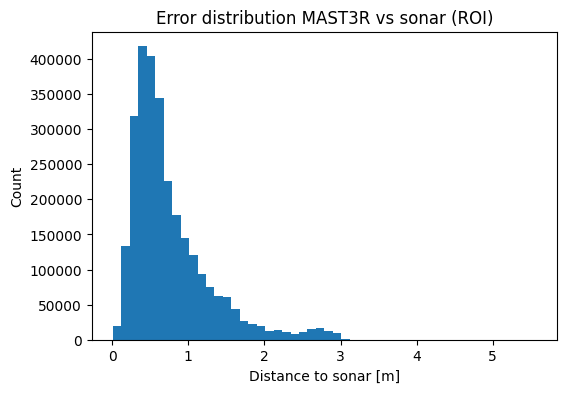

In [14]:
# Cell 13: Histogram of point-to-point distances

plt.figure(figsize=(6, 4))
plt.hist(distances, bins=50)
plt.xlabel("Distance to sonar [m]")
plt.ylabel("Count")
plt.title("Error distribution MAST3R vs sonar (ROI)")
plt.show()


In [15]:
# Cell 14: Percentile statistics of distances

p90 = np.percentile(distances, 90)
p95 = np.percentile(distances, 95)
p99 = np.percentile(distances, 99)

print("90th percentile:", p90)
print("95th percentile:", p95)
print("99th percentile:", p99)


90th percentile: 1.4637638046466974
95th percentile: 1.854538839562362
99th percentile: 2.7450088774381736


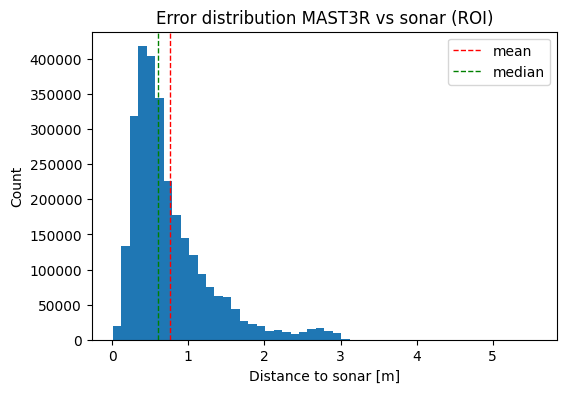

In [16]:
# Cell 15: Histogram with mean and median overlaid

plt.figure(figsize=(6, 4))
plt.hist(distances, bins=50)
plt.axvline(distances.mean(), color="red", linestyle="dashed", linewidth=1, label="mean")
plt.axvline(np.median(distances), color="green", linestyle="dashed", linewidth=1, label="median")
plt.xlabel("Distance to sonar [m]")
plt.ylabel("Count")
plt.title("Error distribution MAST3R vs sonar (ROI)")
plt.legend()
plt.show()


In [17]:
# Cell 16: Convert ROI clouds to numpy for further metrics

sonar_np  = np.asarray(pcd_sonar_roi.points)
mast3r_np = np.asarray(pcd_mast3r_roi.points)

print("Sonar ROI:", sonar_np.shape)
print("MAST3R ROI:", mast3r_np.shape)


Sonar ROI: (6366, 3)
MAST3R ROI: (2829198, 3)


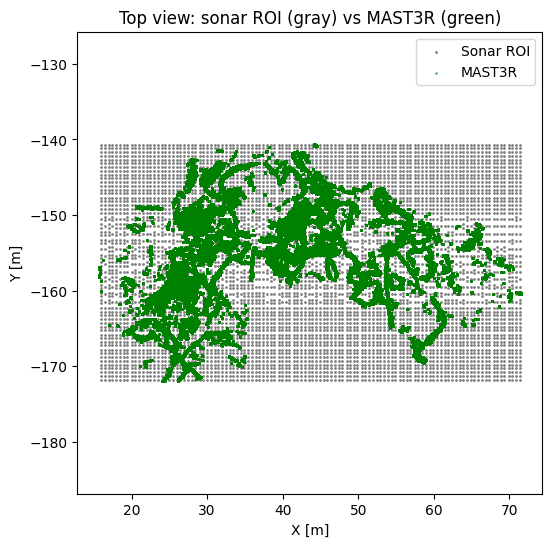

In [18]:
# Cell 17: Top view of sonar ROI and MAST3R ROI

plt.figure(figsize=(6, 6))

plt.scatter(sonar_np[:, 0], sonar_np[:, 1], s=1, c="gray", label="Sonar ROI")
plt.scatter(mast3r_np[:, 0], mast3r_np[:, 1], s=1, c="green", alpha=0.5, label="MAST3R")

plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Top view: sonar ROI (gray) vs MAST3R (green)")
plt.axis("equal")
plt.legend()
plt.show()


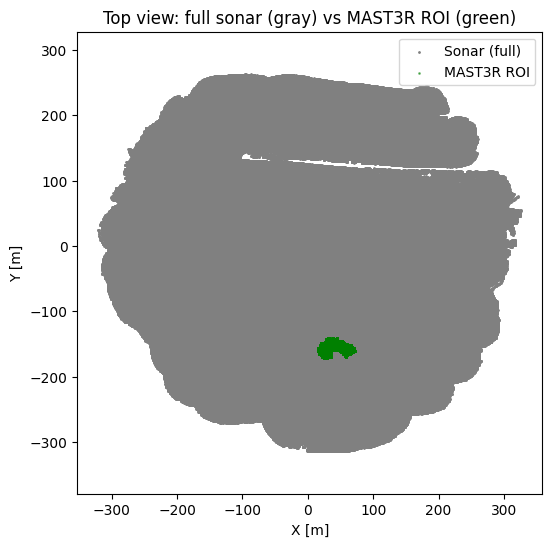

In [19]:
# Cell 18: Top view with full sonar background

sonar_full_np = np.asarray(pcd_sonar_ds.points)

plt.figure(figsize=(6, 6))

plt.scatter(sonar_full_np[:, 0], sonar_full_np[:, 1], s=1, c="gray", label="Sonar (full)")
plt.scatter(mast3r_np[:, 0], mast3r_np[:, 1], s=1, c="green", alpha=0.5, label="MAST3R ROI")

plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Top view: full sonar (gray) vs MAST3R ROI (green)")
plt.axis("equal")
plt.legend()
plt.show()


In [20]:
# Cell 19: Root Mean Squared Error and Mean Absolute Error

rmse = np.sqrt(np.mean(distances ** 2))
mae  = np.mean(distances)

print(f"Root Mean Squared Error (RMSE) (m): {rmse:.4f}")
print(f"Mean Absolute Error (MAE) (m):      {mae:.4f}")


Root Mean Squared Error (RMSE) (m): 0.9293
Mean Absolute Error (MAE) (m):      0.7633


In [21]:
# Cell 20: Threshold accuracy at different distance levels

thresholds = [0.5, 1.0, 1.5, 2.0, 3.0]

for t in thresholds:
    acc = np.mean(distances <= t)
    print(f"Accuracy @ {t:.2f} m: {acc * 100:.2f}%")


Accuracy @ 0.50 m: 37.33%
Accuracy @ 1.00 m: 76.95%
Accuracy @ 1.50 m: 90.72%
Accuracy @ 2.00 m: 95.95%
Accuracy @ 3.00 m: 99.94%


In [22]:
# Cell 21: Absolute relative error on Z component

tree = cKDTree(sonar_np)
dist_nn, idx_nn = tree.query(mast3r_np, k=1)

z_sonar_nn = sonar_np[idx_nn, 2]
z_mast3r    = mast3r_np[:, 2]

eps = 1e-6
abs_rel = np.abs(z_mast3r - z_sonar_nn) / (np.abs(z_sonar_nn) + eps)

abs_rel_mean   = np.mean(abs_rel)
abs_rel_median = np.median(abs_rel)

print(f"Mean absolute relative error:   {abs_rel_mean:.4f}")
print(f"Median absolute relative error: {abs_rel_median:.4f}")


Mean absolute relative error:   0.1599
Median absolute relative error: 0.1085


In [23]:
# Cell 22: Hausdorff distance between MAST3R ROI and sonar ROI

d_m2s = distances
d_s2m = np.asarray(pcd_sonar_roi.compute_point_cloud_distance(pcd_mast3r_roi))

hausdorff = max(d_m2s.max(), d_s2m.max())

print(f"Directed MAST3R -> sonar ROI max (m): {d_m2s.max():.4f}")
print(f"Directed sonar ROI -> MAST3R max (m): {d_s2m.max():.4f}")
print(f"Hausdorff distance (m):              {hausdorff:.4f}")


Directed MAST3R -> sonar ROI max (m): 5.5645
Directed sonar ROI -> MAST3R max (m): 11.8626
Hausdorff distance (m):              11.8626


In [24]:
# Cell 23: Symmetric Chamfer distance between MAST3R ROI and sonar ROI

cd_l2 = 0.5 * (np.mean(d_m2s ** 2) + np.mean(d_s2m ** 2))
cd_l1 = 0.5 * (np.mean(d_m2s) + np.mean(d_s2m))

print(f"Chamfer distance L2 (m^2): {cd_l2:.6f}")
print(f"Chamfer distance L1 (m):   {cd_l1:.6f}")


Chamfer distance L2 (m^2): 6.630871
Chamfer distance L1 (m):   1.676043


In [ ]:
print("==== RAW SONAR DS BOUNDS ====")
sonar_bbox = pcd_sonar_ds.get_axis_aligned_bounding_box()
print("Sonar min:", sonar_bbox.min_bound)
print("Sonar max:", sonar_bbox.max_bound)

print("\n==== MAST3R ALIGNED BOUNDS ====")
mast3r_bbox = pcd_mast3r_aligned.get_axis_aligned_bounding_box()
print("MAST3R min:", mast3r_bbox.min_bound)
print("MAST3R max:", mast3r_bbox.max_bound)

print("\n==== ROI POINT COUNTS ====")
print("Sonar ROI:", len(pcd_sonar_roi.points))
print("MAST3R ROI:", len(pcd_mast3r_roi.points))
